In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), mismatched flags (4))


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing}) (generic function with 1 method)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [10]:
args = Args(use_cuda = true)

Args(0.0003, 256, 10, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [11]:
model = Chain(Dense(1=>20, relu), Dense(20=>1))
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev
x = rand(Float32, 1, 50) |> gdev
y = model(x, ps, st)  # Check for errors here

(Float32[-0.40159088 -0.38622752 … -0.3810224 -0.39230347], (layer_1 = NamedTuple(), layer_2 = NamedTuple()))

In [12]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

(Float32[0.43635908 -0.02072694 … -0.014802111 -0.0019893101; -0.17784306 0.30380124 … -0.07276908 -0.0056274263], Bool[0 0 … 1 1; 1 1 … 0 0])

In [13]:
#test that norm layers are working
model = Chain(BatchNorm(2), Dense(2=>20, relu),  Dense(20=>10),)
ps, st = Lux.setup(Xoshiro(42), model) .|> gdev

((layer_1 = (scale = Float32[1.0, 1.0], bias = Float32[0.0, 0.0]), layer_2 = (weight = Float32[-0.22298728 0.46045378; -1.5991516 0.21926863; … ; -0.8419455 0.6898169; -1.9868723 -2.060835], bias = Float32[0.11489113, 0.6639945, -0.4025346, -0.6888659, -0.4826754, 0.3613354, 0.48929778, -0.21674016, -0.0905359, -0.19842264, -0.70039135, -0.3391459, 0.69077945, 0.6395895, -0.14078076, -0.61794806, 0.6431609, -0.4320272, -0.5562653, 0.6559268]), layer_3 = (weight = Float32[-0.36478028 -0.35009816 … 0.16633585 -0.09001794; 0.11778823 0.23967978 … 0.16875134 0.2501211; … ; 0.18630779 0.37657124 … -0.22133704 0.3819737; -0.28481823 -0.016084503 … 0.33211577 -0.015221041], bias = Float32[-0.08397981, -0.14111775, 0.0053543923, 0.13371398, -0.19779338, -0.114208594, 0.19246913, -0.20375684, -0.072584175, 0.020619141])), (layer_1 = (running_mean = Float32[0.0, 0.0], running_var = Float32[1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [15]:
model(x |> gdev, ps, st)

┌ Warning: `training` is set to `Val{true}()` but is not being used within an autodiff call (gradient, jacobian, etc...). This will be slow. If you are using a `Lux.jl` model, set it to inference (test) mode using `LuxCore.testmode`. Reliance on this behavior is discouraged, and is not guaranteed by Semantic Versioning, and might be removed without a deprecation cycle. It is recommended to fix this issue in your code.
└ @ LuxLib.Utils ~/.julia/packages/LuxLib/kH9PB/src/utils.jl:314


(Float32[-1.6251575 -1.3643706 … -1.0334208 -0.8540355; -1.4790964 -0.66562456 … 0.3910789 0.16788703; … ; 0.36006203 0.19507381 … 1.1235024 0.82358015; -0.7144655 -0.43026197 … 0.4476107 0.1147916], (layer_1 = (running_mean = Float32[0.0017730048, 0.00067927514], running_var = Float32[0.9039085, 0.90418065], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

# Test FP32

In [16]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

build_mlp (generic function with 1 method)

In [17]:
x = x |> gdev

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
  0.436359  -0.0207269   0.0444016  -0.0051785   …  -0.0148021  -0.00198931
 -0.177843   0.303801   -0.0365956  -0.00554021     -0.0727691  -0.00562743

In [18]:
size(x)

(2, 256)

In [19]:
model_f, ps_f, st_f = build_mlp(args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#33#35"}, layer_3::WrappedFunction{var"#34#36"}, layer_4::PhasorDense, layer_5::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#33), layer_3 = WrappedFunction(#34), layer_4 = PhasorDense((2, 128)), layer_5 = PhasorDense((128, 2))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.025199654 0.005086061; 0.021546587 -0.11127125; … ; 0.15865159 -0.030458387; -0.24032864 0.049523916], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[0.12666641 

In [20]:
ps_f = ps_f |> gdev
st_f = st_f |> gdev

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [22]:
y_f, _ = model_f(x, ps_f, st_f) 

(Float32[-0.020149658 0.045700043 … 0.014530507 0.011981527; -0.02249537 -0.00995539 … -0.054838575 -0.023126202], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [23]:
y_f |> typeof

CuArray{Float32, 2, CUDA.DeviceMemory}

In [24]:
size(y_f)

(2, 256)

In [25]:
losses_f, ps_train_f, st_train_f = train(model_f, ps_f, st_f, train_loader, args)

[ Info: Training on CUDA GPU


(Any[0.4987212113809998, 0.521122191794009, 0.5082742479009222, 0.5136231814811849, 0.49438453474908484, 0.4974023651358642, 0.4872463278624626, 0.4812212228282078, 0.48914629215988037, 0.48157892148610654  …  0.05532420755450476, 0.043126595831990286, 0.043077381269434736, 0.04251557404212223, 0.059209086565330415, 0.04838971455472543, 0.05391948963310008, 0.05201482573252102, 0.0604854485165138, 0.04945148768182123], (layer_1 = (bias = Float32[-0.19326492; -0.1934431;;], scale = Float32[0.8069064; 0.7923898;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.041125026 0.010296932; 0.0069805593 -0.09867007; … ; 0.15147264 -0.017196883; -0.24489555 0.021723168], bias_real = Float32[0.98994374, 1.0200062, 1.0263494, 0.98612386, 0.86550725, 0.973798, 0.97416484, 0.9831198, 0.9938522, 0.973759  …  0.98657197, 1.0009376, 1.0316812, 1.0203657, 0.9861856, 1.0052575, 0.98179805, 0.9936021, 1.0099664, 0.9952298], bias_imag = Float32[-0.0047133034, -0.003984232, 0

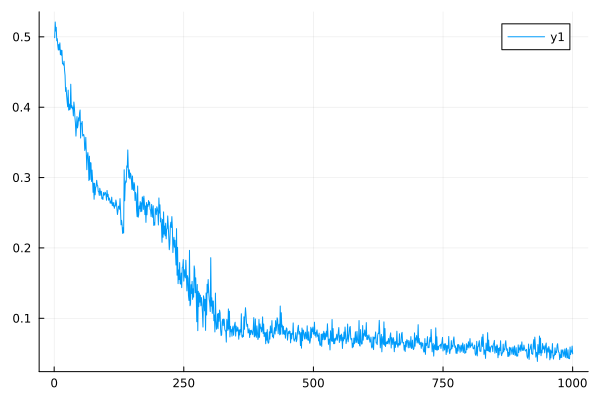

In [26]:
plot(losses_f)

In [36]:
import .PhasorNetworks: loss_and_accuracy, SpikingTypes

In [37]:
args.use_cuda

true

In [38]:
yfc = y_f |> cdev

2×256 Matrix{Float32}:
 -0.0201497   0.0457      -0.0682223    0.0168105  …   0.0145305   0.0119815
 -0.0224954  -0.00995539  -0.00617258  -0.0253506     -0.0548386  -0.0231262

In [40]:
loss_and_accuracy(test_loader, model_f, ps_train_f |> gdev, st_train_f |> gdev, args)

(0.0501451900814048, 0.98203125)

In [41]:
ps_train_f.layer_1

(bias = Float32[-0.19326492; -0.1934431;;], scale = Float32[0.8069064; 0.7923898;;])

In [42]:
yt_f, _ = model_f(x, ps_train_f, st_train_f)

(Float32[-0.06825633 0.104416214 … 0.50418824 0.556367; 0.3852908 0.41843346 … 0.12666069 0.03351757], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

# Test spiking behavior

In [90]:
function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), 
                    x -> tanh.(x),
                    MakeSpiking(spk_args, repeats),
                    PhasorDense(2 => 128, return_solution=true),)
                    #PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [91]:
spk_model_f, ps_spk, st_spk = build_spiking_mlp(args, spk_args)

(Chain{@NamedTuple{layer_1::LayerNorm{Tuple{Int64}, typeof(identity), Float32, typeof(zeros32), typeof(ones32), Colon, Static.True}, layer_2::WrappedFunction{var"#47#48"}, layer_3::MakeSpiking, layer_4::PhasorDense}, Nothing}((layer_1 = LayerNorm((2,), affine=true, dims=Colon()), layer_2 = WrappedFunction(#47), layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 10, (0.0, 10.0f0), 0.0), layer_4 = PhasorDense((2, 128))), nothing), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[0.08248617 -0.005737242; 0.0043084864 -0.2140992; … ; -0.1184511 -0.03885449; 0.013063874 0.045514792], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])), (laye

In [95]:
ps_spk = ps_spk |> gdev
st_spk = st_spk |> gdev

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

In [77]:
import .PhasorNetworks: phase_to_train

In [78]:
ts = phase_to_time(x, spk_args=spk_args, offset=0.0f0)

2×256 CuArray{Float32, 2, CUDA.DeviceMemory}:
 0.71818   0.489637  0.522201  0.497411  …  0.503094  0.492599  0.499005
 0.411078  0.651901  0.481702  0.49723      0.498118  0.463615  0.497186

In [79]:
import .PhasorNetworks: phase_to_train

In [80]:
a = phase_to_train(x, spk_args=spk_args, repeats=10, offset=0.0f0)

SpikeTrainGPU(CartesianIndex{2}[CartesianIndex(1, 1), CartesianIndex(2, 1), CartesianIndex(1, 2), CartesianIndex(2, 2), CartesianIndex(1, 3), CartesianIndex(2, 3), CartesianIndex(1, 4), CartesianIndex(2, 4), CartesianIndex(1, 5), CartesianIndex(2, 5)  …  CartesianIndex(1, 252), CartesianIndex(2, 252), CartesianIndex(1, 253), CartesianIndex(2, 253), CartesianIndex(1, 254), CartesianIndex(2, 254), CartesianIndex(1, 255), CartesianIndex(2, 255), CartesianIndex(1, 256), CartesianIndex(2, 256)], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  503, 504, 505, 506, 507, 508, 509, 510, 511, 512], Float32[0.7181795, 0.41107845, 0.48963654, 0.65190065, 0.5222008, 0.48170218, 0.49741074, 0.4972299, 0.46343565, 0.50226045  …  9.315895, 9.582314, 9.510534, 9.509322, 9.503094, 9.498118, 9.492599, 9.463615, 9.499005, 9.497187], (2, 256), 512, 0.0f0)

In [81]:
import .PhasorNetworks: gaussian_kernel_gpu

In [82]:
a.times

5120-element CuArray{Float32, 1, CUDA.DeviceMemory}:
 0.7181795
 0.41107845
 0.48963654
 0.65190065
 0.5222008
 0.48170218
 0.49741074
 0.4972299
 0.46343565
 0.50226045
 0.50755596
 0.5081103
 0.6949215
 ⋮
 9.707568
 9.488842
 9.315895
 9.582314
 9.510534
 9.509322
 9.503094
 9.498118
 9.492599
 9.463615
 9.499005
 9.497187

In [83]:
spk_args.t_window

0.01f0

In [84]:
import .PhasorNetworks: bias_current

In [85]:
function bias_current(phase::CuArray{<:Real}, mag::CuArray{<:Real}, t::Real, t_offset::Real, spk_args::SpikingArgs)
    #what times to the bias values correlate to?
    times = phase_to_time(phase, spk_args=spk_args, offset=t_offset)
    #determine the time within the cycle
    t = Float32(mod(t, spk_args.t_period))
    #add the active currents, scaled by the gaussian kernel & bias magnitude
    bias = mag .* gaussian_kernel_gpu.(times, t, Float32(spk_args.t_window))

    return bias
end

bias_current (generic function with 4 methods)

In [96]:
y_spk_f = spk_model_f(x, ps_spk, st_spk)

(ODESolution{ComplexF32, 3, Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}}, Nothing, ODEProblem{CuArray{ComplexF32, 2, CUDA.DeviceMemory}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#80"{SpikingArgs, SpikeTrainGPU, CuArray{Float32, 2, CUDA.DeviceMemory}, CuArray{ComplexF32, 1, CUDA.DeviceMemory}, Main.PhasorNetworks.var"#27#28"{Float32, Float32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{false, SciML

In [108]:
typeof(y_spk_f[1])

ODESolution{ComplexF32, 3, Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}}, Nothing, ODEProblem{CuArray{ComplexF32, 2, CUDA.DeviceMemory}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, Main.PhasorNetworks.var"#dzdt#80"{SpikingArgs, SpikeTrainGPU, CuArray{Float32, 2, CUDA.DeviceMemory}, CuArray{ComplexF32, 1, CUDA.DeviceMemory}, Main.PhasorNetworks.var"#27#28"{Float32, Float32}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqCore.InterpolationData{ODEFunction{false, SciMLB

In [119]:
soln = y_spk_f[1]

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.060000000000000005
  0.07
  0.08
  0.09
  0.09999999999999999
  0.10999999999999999
  0.11999999999999998
  ⋮
  9.889999999999834
  9.899999999999833
  9.909999999999833
  9.919999999999833
  9.929999999999833
  9.939999999999833
  9.949999999999832
  9.959999999999832
  9.969999999999832
  9.979999999999832
  9.989999999999831
 10.0
u: 1001-element Vector{CuArray{ComplexF32, 2, CUDA.DeviceMemory}}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [-1.3269921f-21 - 1.0937245f-23im 0.0f0 - 0.0f0im … -0.0f0 + 0.0f0im -0.0f0 + 0.0f0im; -4.9519953f-20 - 4.0815f-22im 0.0f0 - 0.0f0im … -0.0f0 + 0.0f0im -0.0f0 + 0.0f0im;

In [121]:
soln.([0.05f0, 0.50f0])

2-element Vector{CuArray{ComplexF64, 2, CUDA.DeviceMemory}}:
 [-1.0967800156331446e-12 - 1.57957669117791e-14im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -4.0929026301302756e-11 - 5.894574939283114e-13im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; … ; -7.427756020442506e-12 - 1.0697414314680145e-13im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 8.700995740461279e-12 + 1.253112740003131e-13im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im]
 [0.017743093199997208 + 0.0011110049140710219im 0.02011421906690774 + 0.002650845793395665im … 0.020178108889495484 + 0.0022371960409801237im 0.020225110925875686 + 0.0018317869502900092im; 0.022392490646961735 - 0.0038970759056102516im 0.017745610802208295 + 0.0013221302116335075im … 0.015501673999764229 - 0.005595855395069657im 0.010564446106930522 - 0.0007804326772362786im; … ; 0.018482073768005626 + 0.00031501653360906004im 0.014026268816705635 - 0.0007643028373171114im … 0.013439521733022966 - 0.0016893504606593735im 0.012283969669707098 - 4.182971907491719e-5im; 0.01

In [126]:
import .PhasorNetworks: solution_to_train, generate_cycles

In [127]:
function solution_to_train(sol::Union{ODESolution,Function}, tspan::Tuple{<:Real, <:Real}; spk_args::SpikingArgs, offset::Real)
    #determine the ending time of each cycle
    cycles = generate_cycles(tspan, spk_args, offset)

    #sample the potential at the end of each cycle
    u = solution_to_potential(sol, cycles)
    spiking = abs.(u) .> spk_args.threshold
    
    #convert the phase represented by that potential to a spike time
    tms = potential_to_time(u, cycles, spk_args = spk_args)
    return tms

    #return only the times where the neuron is spiking
    cut_index = i -> CartesianIndex(Tuple(i)[1:end-1])
    inds = findall(spiking)
    tms = tms[inds]
    inds = cut_index.(inds)
    train = SpikeTrain(inds, tms, size(u)[1:end-1], offset + spiking_offset(spk_args))

    return train
end

solution_to_train (generic function with 1 method)

In [128]:
solution_to_train(y_spk_f[1], (0.0f0, 10.0f0), spk_args=spk_args, offset=0.0)

128×256×10 CuArray{Float64, 3, CUDA.DeviceMemory}:
[:, :, 1] =
 1.75223  1.74387  1.75657  1.74701  …  1.75164  1.74909  1.74589  1.74759
 1.77049  1.74003  1.77682  1.76137     1.74585  1.76042  1.7824   1.76146
 1.74975  1.76175  1.73886  1.75882     1.74562  1.75378  1.7649   1.75748
 1.76002  1.74595  1.76051  1.75579     1.74779  1.75482  1.76663  1.75568
 1.74902  1.7636   1.73673  1.75934     1.7453   1.75381  1.76521  1.75786
 1.74426  1.76677  1.73228  1.7558   …  1.74679  1.75114  1.75566  1.75447
 1.7612   1.7463   1.76139  1.75777     1.74692  1.75612  1.77085  1.7575
 1.76199  1.74581  1.76257  1.75817     1.74678  1.75653  1.77205  1.75792
 1.75466  1.75348  1.74964  1.75761     1.74657  1.75447  1.76637  1.75685
 1.7575   1.75084  1.75421  1.75849     1.74633  1.75559  1.76978  1.75784
 1.75228  1.75099  1.75043  1.75269  …  1.74885  1.75165  1.75619  1.75245
 1.751    1.74466  1.75523  1.74682     1.75167  1.74881  1.74484  1.74737
 1.74327  1.74265  1.75351  1.74194   

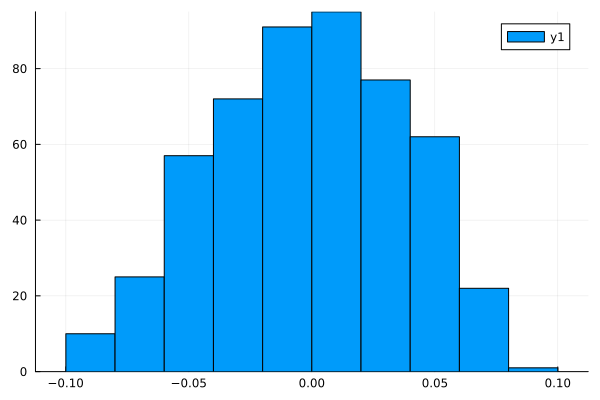

In [ ]:
histogram(vec(p_spk_f[5,:,:]))

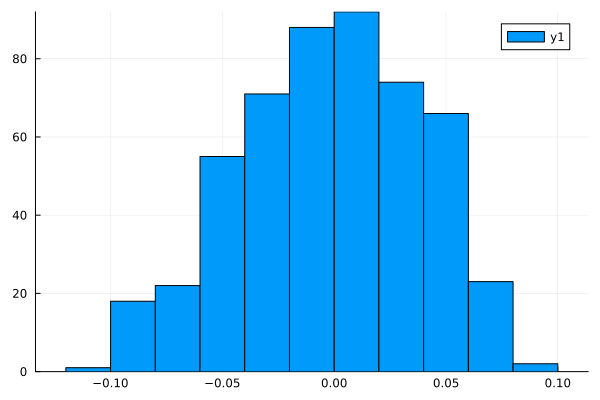

In [ ]:
histogram(vec(p_spk_f[6,:,:]))

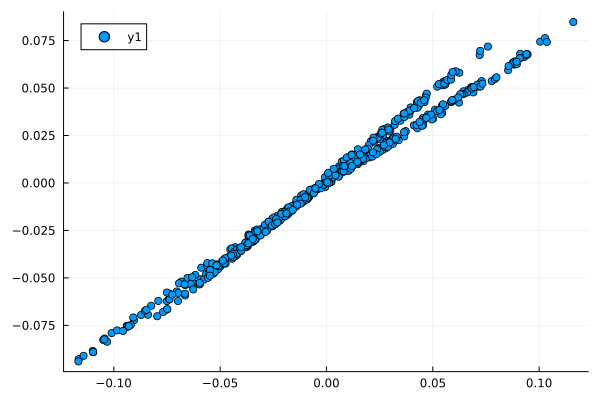

In [ ]:
scatter(vec(y_f), vec(p_spk_f[5,:,:]))

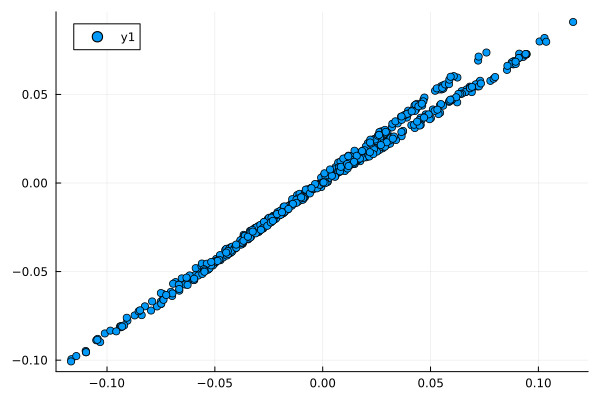

In [ ]:
scatter(vec(y_f), vec(p_spk_f[6,:,:]))

In [ ]:
cycle_correlation(y_f, p_spk_f)

10-element Vector{Float64}:
 NaN
   0.9574926180865236
   0.9827656087091672
   0.9911054153162355
   0.9945394086500386
   0.9961571724700357
   0.9969892714369741
   0.9974438152049062
   0.9977029173522644
   0.9883285067094865

In [30]:
yt_spk_f, _ = spk_model_f(x, ps_train_f, st_train_f)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [31]:
pt_f = train_to_phase(yt_spk_f.train, spk_args=spk_args);

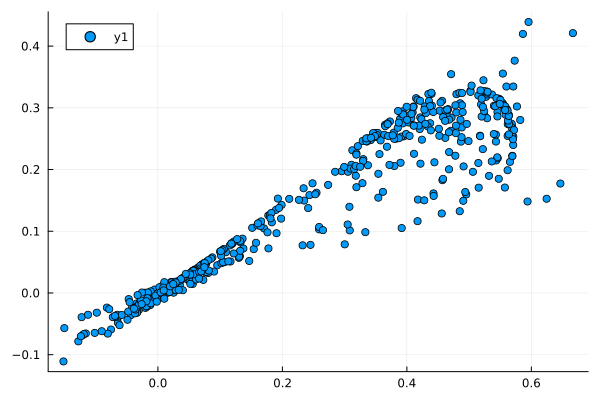

In [32]:
scatter(vec(yt_f), vec(pt_f[end-1,:,:]))

In [33]:
cycle_correlation(yt_f, pt_f)

10-element Vector{Float64}:
 0.006461719595410191
 0.7612329428711189
 0.7876563240679477
 0.8183012011102203
 0.8496381593542799
 0.8793015402733626
 0.9056243865568043
 0.9278058184415781
 0.9457683686352797
 0.6378516516150825

In [34]:
yt_spk_f.train.indices |> size

(5120,)

In [35]:
seed = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [38]:
dropout(seed, yt_spk_f, 0.2, true, 0.8, nothing)

(SpikingCall(Spike Train: (2, 256) with 4121 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (), Xoshiro(0xc9497a0b315534d1, 0x84c41edb3eb2fc63, 0x9f23dfd6d796c4a7, 0x0d0963d3e36f4b59, 0xc90c4a0730db3f7e))

In [39]:
dl = Chain(Dropout(0.4),)

Dropout(0.4)

In [40]:
psdr, stdr = Lux.setup(seed, dl)

(NamedTuple(), (rng = Xoshiro(0x40840703ec8883eb, 0xd2aebb06d8710c15, 0x6bdcd8b81e05f076, 0xb6e75139afa11bbb, 0xc90c4a0730db3f7e), training = Val{true}()))

In [41]:
yt_spk_f

SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0))

In [42]:
dl(yt_spk_f, psdr, stdr)

(SpikingCall(Spike Train: (2, 256) with 3021 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (rng = Xoshiro(0x33609a83a1f45229, 0xffc7dfad55046e0f, 0x74d3cbb94ddf3f59, 0xc5ac587b9dc31915, 0xc90c4a0730db3f7e), training = Val{true}()))

In [43]:
3021 / 5120

0.5900390625

In [36]:
dropout(yt_f)

LoadError: MethodError: no method matching dropout(::Matrix{Float64})

[0mClosest candidates are:
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m; dims, invp) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray{T1, N}[39m, [91m::AbstractArray{T2, N}[39m, [91m::T[39m, [91m::Val[39m, [91m::Val[39m, [91m::T[39m; dims) where {T, T1, T2, N}
[0m[90m   @[39m [35mLuxLib[39m [90m[4mdeprecated.jl:103[24m[39m
[0m  dropout([91m::AbstractRNG[39m, [91m::AbstractArray[39m, [91m::AbstractArray[39m, [91m::T[39m, [91m::Static.StaticBool[39m, [91m::Static.True[39m, [91m::T[39m, [91m::Any[39m) where T
[0m[90m   @[39m [35mLuxLib[39m [90m~/.julia/packages/LuxLib/vG8lL/src/api/[39m[90m[4mdropout.jl:50[24m[39m
[0m  ...
